# Proyecto "Image Denoising"

Carlos Sánchez Polo y Jesús Martínez Leal

In [1]:
#NumPy: numerical scientific computing 
import numpy as np

#Scikit-learn: machine learning
from sklearn.decomposition import PCA, KernelPCA

#Matplotlib: plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

#SciPy: scientific tools
import scipy.io.matlab as matlab

#OpenCV: computer vision
import cv2


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Carga de los datos

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser='auto')
X = MinMaxScaler().fit_transform(X)

Dividimos en train y test e introducimos ruido a las imágenes.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size=1_000, test_size=100)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

# Representación de las imágenes

In [4]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

La siguiente función permite presentar dos bloques de números en paralelos para comparar. Por ejemplo las imágenes con ruido, y las imágenes tratadas para reducirlo.

In [5]:
def plot_parallel(X_clean, X_noisy, title_clean, title_noisy):
    """Small helper function to plot 100 digits."""
    # Creamos una figura más ancha para acomodar ambos conjuntos de datos
    fig, axs = plt.subplots(nrows=10, ncols=20, figsize=(10, 5)) 

    # Título y posición central para datos limpios
    axs[0, 4].set_title(title_clean, fontsize=10)

    # Título y posición central para datos ruidosos
    axs[0, 14].set_title(title_noisy, fontsize=10)

    for i in range(10):
        # Plot clean data
        for j, img in enumerate(X_clean[i*10:(i+1)*10]): # Los primeros 10 subplots para los datos limpios
            ax = axs[i, j]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

        # Plot noisy data
        for j, img in enumerate(X_noisy[i*10:(i+1)*10]): # Los siguientes 10 subplots para los datos ruidosos
            ax = axs[i, j+10]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Vamos a usar el Mean Square Error (o error cuadrático medio) como medida del error. Cuando limpiemos las imágenes, tendremos que tener alguna referencia que nos permita de forma numérica saber si nuestras imágenes están mejor o peor que antes.

In [6]:
def calcular_mse(nuevas, originales=X_train):
    num_imagenes = len(originales)
    total_mse = 0.0

    for i in range(num_imagenes):
        mse = np.mean((originales[i] - nuevas[i])**2)
        total_mse += mse

    mse = total_mse / num_imagenes
    return mse

A continuación se ve los números originales y los números tras introducirles ruido

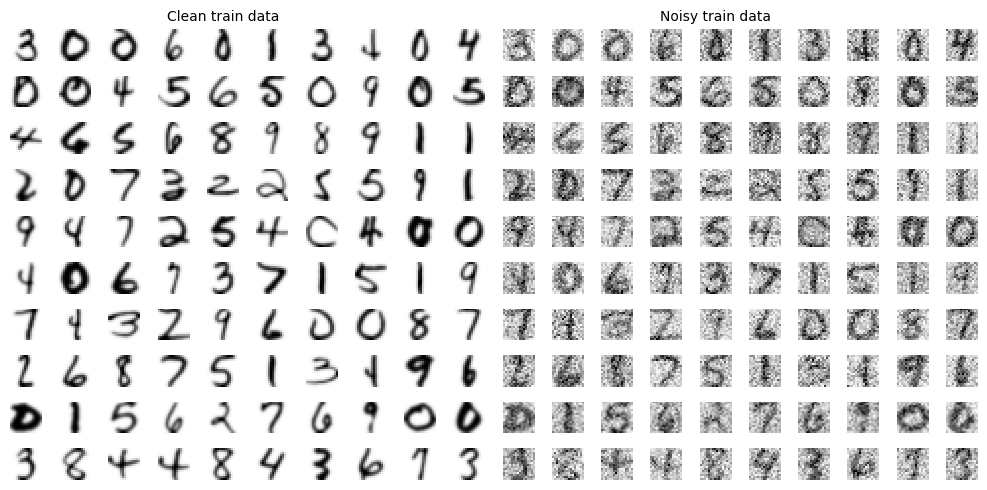

In [7]:
plot_parallel(X_train, X_train_noisy, "Clean train data", "Noisy train data")

# Ejercicio.

### Intenta quitar el ruido de las imágenes de test utilizando los métodos vistos en clase. Cuantifica los resultados cualitativamente y cuantitativamente utilizando MSE. Justifica todas tus respuestas.

Ajustar los hiperparámetros para obtener los mejores resultados posibles (número de componentes, tipo de kernel, gamma ...)

Hemos hecho varias pruebas previas para comprobar en que rango de valores nos debemos mover para quitar el ruido a nuestras imágenes. El procedimiento es el siguiente: Aplicamos KPCA, probando con distintos kernels y valores de gamma. Nos quedamos con el mejor denosing. Sobre ese nuevo conjunto de imágenes procesadas volvemos a aplicar pca de forma iterativa hasta que el MSE alcance un mínimo. Para cada iteración nos guardamos los hiperparámetros de nuestro mejor modelo, que luego aplicaremos a nuestros datos de test, puesto que hasta habremos estado probando con los de entrenamiento.

In [8]:
best_mse = calcular_mse(nuevas=X_train_noisy)
recuento = 0

lista = np.arange(0.00125, 0.10001, 0.00125).tolist()


for kernel in ['rbf', 'poly','linear']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_train_noisy) 
        X_kpca = kpca.transform(X_train_noisy) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(nuevas=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.00125
MSE: 0.0696265158804561
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.0025
MSE: 0.06610842368765545
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.00375
MSE: 0.06173932325213362
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.005
MSE: 0.05731993623593275
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.00625
MSE: 0.0532396520399035
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.007500000000000001
MSE: 0.04963374119603844
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.008749999999999999
MSE: 0.04651368116440709
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.01
MSE: 0.04384068706763245
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.01125
MSE: 0.04156067768986962
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.012499999999999999
MSE: 0.039619162757840894
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.01375
MSE: 0.03796681021369576
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.015
MSE: 0.03656096534820109
-----
Probando modelo  13

Hemos probado 240 modelos y hemos seleccionado aquel cuyos hiperparámetros reducen más el MSE. Transformamos de forma definitiva nuestras imágenes con ruido usando este modelo seleccionado. Representamos las nuevas imágenes con mucho menor ruido:

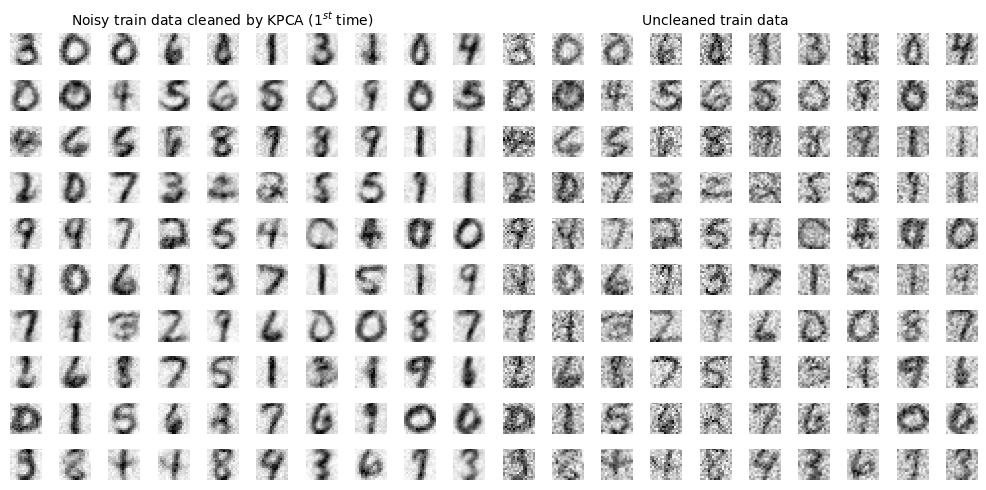

In [9]:
gamma = 0.01375
kernel = 'poly'

kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_train_noisy) 
X_kpca = kpca.transform(X_train_noisy) 
X_back_m1 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m1, X_train_noisy, "Noisy train data cleaned by KPCA ($1^{st}$ time)", "Uncleaned train data")


Repetimos el mismo proceso, pero esta vez tomamos como imágenes a limpiar las obtenidas en el anterior paso. Seguimos comparando con las imágenes originales.

In [10]:
best_mse = calcular_mse(nuevas=X_back_m1)
recuento = 0
mse_lista_m2 = []


lista = np.arange(0.00125, 0.15001, 0.00125).tolist()


for kernel in ['rbf', 'poly']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m1) 
        X_kpca = kpca.transform(X_back_m1) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(nuevas=X_back)
        if kernel == 'poly':
            mse_lista_m2.append(mse)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.00125
MSE: 0.0700027309333521
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.0025
MSE: 0.06722738200527459
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.00375
MSE: 0.06357125400846185
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.005
MSE: 0.05969149817571288
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.00625
MSE: 0.055968021365508415
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.007500000000000001
MSE: 0.052565264490399735
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.008749999999999999
MSE: 0.0495262987734411
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.01
MSE: 0.046838573950494025
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.01125
MSE: 0.04446881737467767
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.012499999999999999
MSE: 0.04237891046324367
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.01375
MSE: 0.0405322947581825
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.015
MSE: 0.038896168692460556
-----
Probando modelo  

Una vez más nos quedamos con el modelo que menor MSE presenta. Las imágenes han sido tratadas por segunda vez. Despues de esta segunda iteración habremos probado un totlal de 480 modelos, barriendo por hiperparámetros.

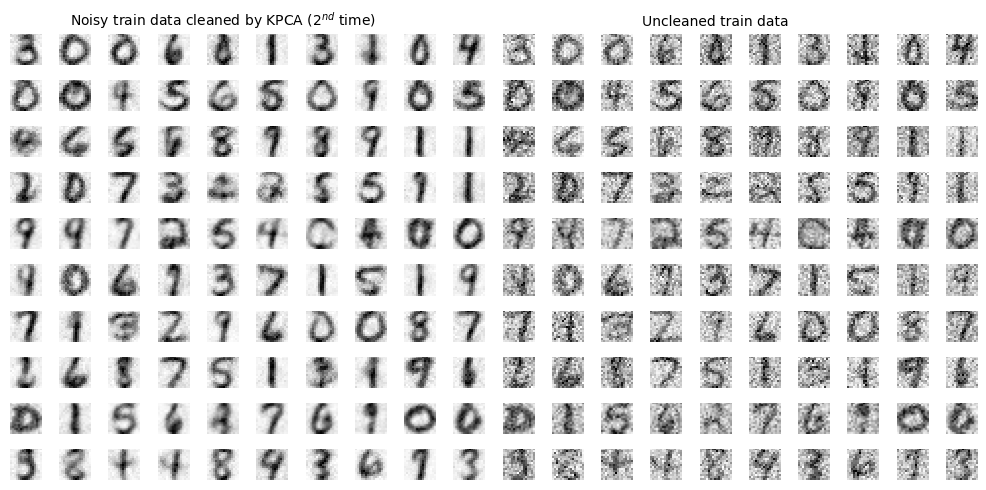

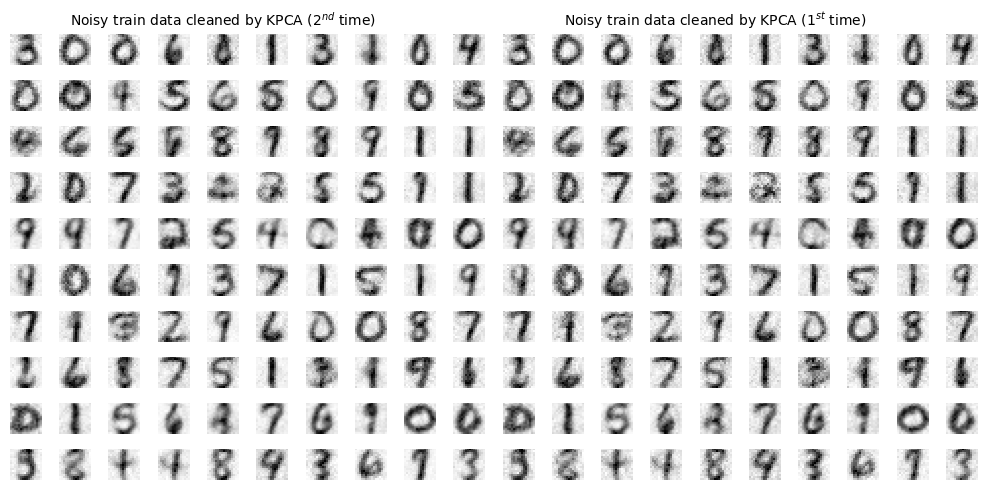

In [11]:
gamma = 0.06625
kernel = 'poly'

kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m1) 
X_kpca = kpca.transform(X_back_m1) 
X_back_m2 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m2, X_train_noisy, "Noisy train data cleaned by KPCA ($2^{nd}$ time)", "Uncleaned train data")
plot_parallel(X_back_m2, X_back_m1, "Noisy train data cleaned by KPCA ($2^{nd}$ time)", "Noisy train data cleaned by KPCA ($1^{st}$ time)")


Aunque podríamos seguir así indefinidamente, iteraremos una tercera y última vez. Construiremos nuestra tercera generación de imágenes procesadas a partir de la segunda generación que obtuvimos a partir de a primera que obtuvimos a partir de las imágenes con ruido. Esta vez el barrido en gamma es mayor:

In [12]:
best_mse = calcular_mse(nuevas=X_back_m1)
recuento = 0

lista = np.arange(0.00125, 0.15001, 0.00125).tolist()


for kernel in ['rbf', 'poly']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m2) 
        X_kpca = kpca.transform(X_back_m2) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(nuevas=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.00125
MSE: 0.07000915748354483
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.0025
MSE: 0.06724713324579466
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.00375
MSE: 0.0636057718141562
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.005
MSE: 0.05973985014073493
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.00625
MSE: 0.0560288826201653
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.007500000000000001
MSE: 0.0526375019157786
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.008749999999999999
MSE: 0.04960900684551493
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.01
MSE: 0.046931018002803616
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.01125
MSE: 0.044570392626682366
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.012499999999999999
MSE: 0.04248911500965255
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.01375
MSE: 0.040650705853889565
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.015
MSE: 0.03902241999467535
-----
Probando modelo  1

Comprobamos como el mejor modelo es el último en ser probado. Ampliamos el rango de búsqueda. Habiendo probado con $\gamma \in (0, 0.15)$, ahora veremos que ocurre con $\gamma \in (0.15, 3)$. (Hasta el momento hemos probado un total de 720 modelos).

In [13]:
best_mse = calcular_mse(nuevas=X_back_m2)
recuento = 0

lista = np.arange(0.15000, 3.0, 0.01000).tolist()


for kernel in ['rbf', 'poly']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m2) 
        X_kpca = kpca.transform(X_back_m2) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(nuevas=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.15
MSE: 0.022495826276510218
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.16
MSE: 0.02264786012532625
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.17
MSE: 0.02281288032434787
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.18000000000000002
MSE: 0.022987427158832282
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.19000000000000003
MSE: 0.023168723600456673
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.20000000000000004
MSE: 0.023354507823285818
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.21000000000000005
MSE: 0.023542914892358734
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.22000000000000006
MSE: 0.023732392096109552
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.23000000000000007
MSE: 0.023921637688070464
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.24000000000000007
MSE: 0.024109556092736927
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.2500000000000001
MSE: 0.024295224743599526
-----
Probando modelo  12
Kernel:  rbf
G

Después de probar con la segunda generación de imágenes, (570 modelos), obtenemos un valor de gamma bastante más alto que lo que estábamos acostumnbrados: 0.25. Generamos la tercera generación de números tratados y la representamos:

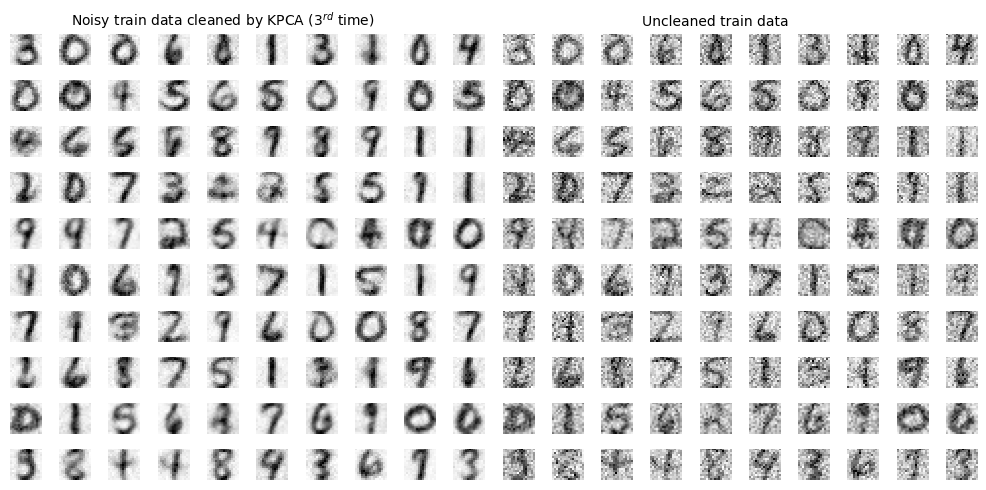

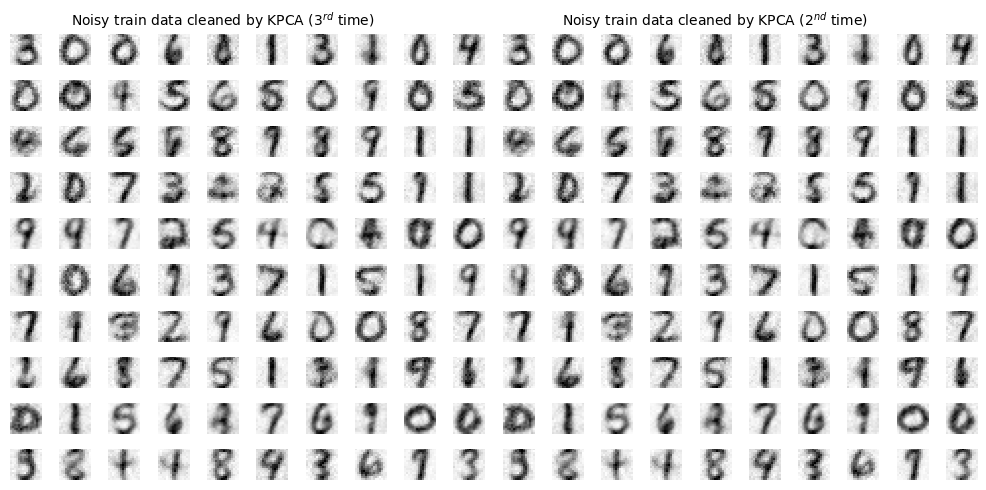

In [14]:
kernel="poly"
gamma = 0.25

kpca = KernelPCA(kernel= kernel, gamma = gamma ,fit_inverse_transform=True).fit(X_back_m2)
X_kpca = kpca.transform(X_back_m2)
X_back_m3 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m3, X_train_noisy, "Noisy train data cleaned by KPCA ($3^{rd}$ time)", "Uncleaned train data")
plot_parallel(X_back_m3, X_back_m2, "Noisy train data cleaned by KPCA ($3^{rd}$ time)", "Noisy train data cleaned by KPCA ($2^{nd}$ time)")


Notamos que el salto en calidad existe pero es menor que el obtenido entre la primera y segunda generación de imágenes tratadas. Ahora, usando estos valores, vamos a transformar los datos de test para evaluar que tal funciona este procedimiento con datos no vistos previamente:

MSE 0: 0.061341634382292426
MSE 1: 0.03159296842554672


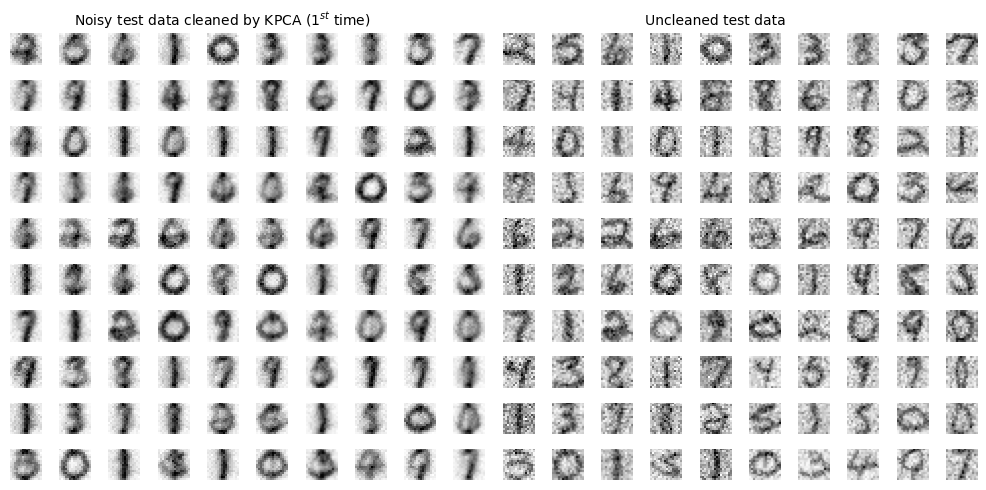

In [15]:
gamma_1 = 0.01375
kernel_1 = 'poly'

mse_test_0 = calcular_mse(nuevas=X_test_noisy, originales=X_test)
print("MSE 0:", mse_test_0)

kpca_1 = KernelPCA(kernel=kernel_1, gamma=gamma_1, fit_inverse_transform=True).fit(X_test_noisy) 
X_kpca_1 = kpca_1.transform(X_test_noisy) 
X_back_m1_test = kpca_1.inverse_transform(X_kpca_1)
mse_test_1 = calcular_mse(nuevas=X_back_m1_test, originales=X_test)
print("MSE 1:", mse_test_1)


plot_parallel(X_back_m1_test, X_test_noisy, "Noisy test data cleaned by KPCA ($1^{st}$ time)", "Uncleaned test data")

MSE 2: 0.0361090253311589


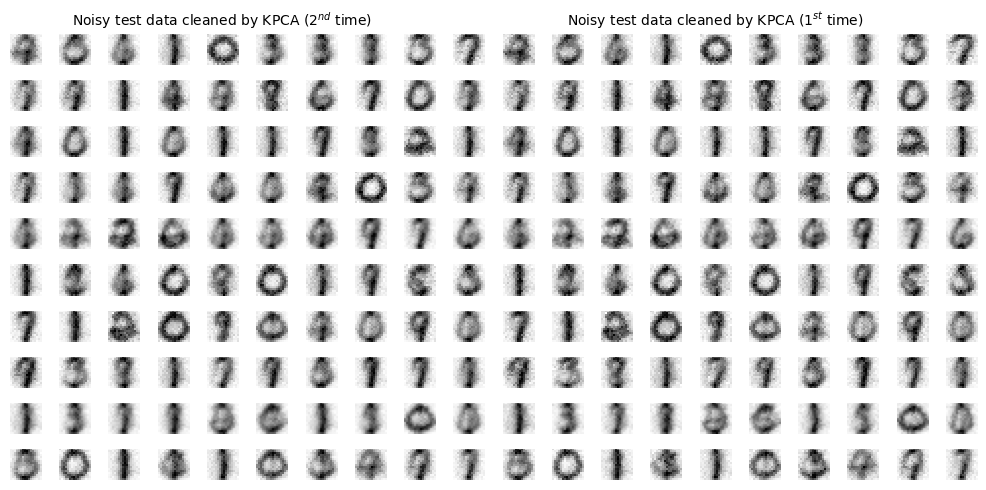

In [16]:
gamma_2 = 0.06625
kernel_2 = 'poly'


kpca_2 = KernelPCA(kernel=kernel_2, gamma=gamma_2, fit_inverse_transform=True).fit(X_back_m1_test)
X_kpca_2 = kpca_2.transform(X_back_m1_test)
X_back_m2_test = kpca_2.inverse_transform(X_kpca_2)
mse_test_2 = calcular_mse(nuevas=X_back_m2_test, originales=X_test)
print("MSE 2:", mse_test_2)

plot_parallel(X_back_m2_test, X_back_m1_test, "Noisy test data cleaned by KPCA ($2^{nd}$ time)", "Noisy test data cleaned by KPCA ($1^{st}$ time)")


MSE 3: 0.036114473796172525


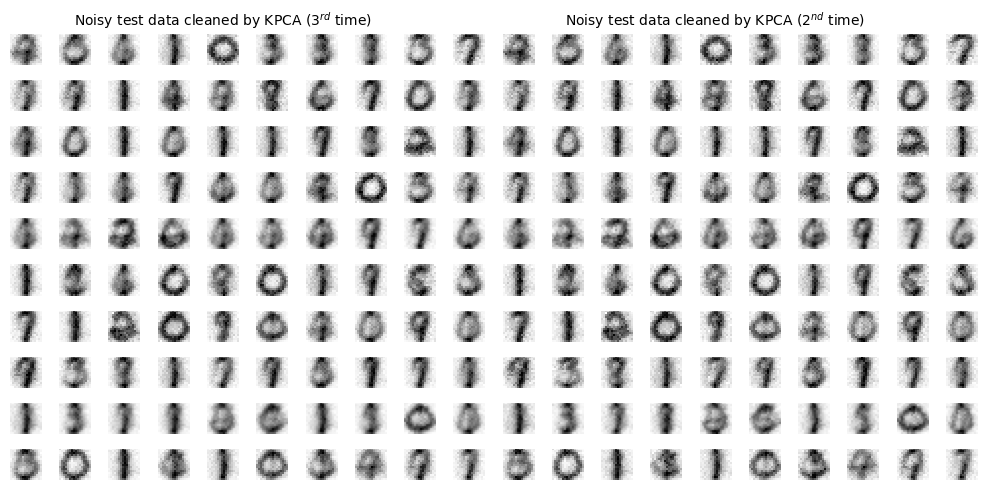

In [17]:

gamma_3 = 0.25000
kernel_3 = 'poly'
kpca_3 = KernelPCA(kernel=kernel_3, gamma=gamma_3, fit_inverse_transform=True).fit(X_back_m2_test)
X_kpca_3 = kpca_3.transform(X_back_m2_test)
X_back_m3_test = kpca_3.inverse_transform(X_kpca_3)
mse_test_3 = calcular_mse(nuevas=X_back_m3_test, originales=X_test)
print("MSE 3:", mse_test_3)


plot_parallel(X_back_m3_test, X_back_m1_test, "Noisy test data cleaned by KPCA ($3^{rd}$ time)", "Noisy test data cleaned by KPCA ($2^{nd}$ time)")


Desgraciadamente comrpobamos como los resultados obtenidos NO son los esperados. Veamos la evolución relativa del MSE:

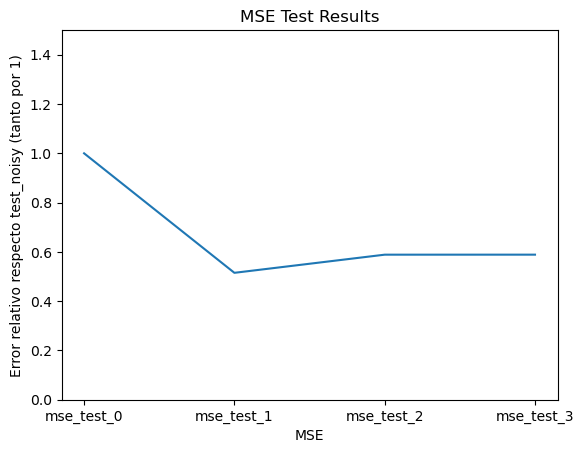

In [18]:


# Create a dataframe with the MSE values
data = {'MSE': ['mse_test_0', 'mse_test_1', 'mse_test_2', 'mse_test_3'],
        'Value': [mse_test_0 / mse_test_0, mse_test_1 / mse_test_0, mse_test_2 / mse_test_0, mse_test_3 / mse_test_0]}
df = pd.DataFrame(data)

# Plot the MSE values
sns.lineplot(x='MSE', y='Value', data=df)
plt.xlabel('MSE')
plt.ylabel('Error relativo respecto test_noisy (tanto por 1)')
plt.title('MSE Test Results')
plt.ylim(0, 1.5)  # Set the y-axis limits
plt.show()


Después de todo el esfuerzo invertido, no conseguimos que los datos de test mejoren tanto como los de train usando los hiperparámetros que minimizaban el MSE. Aunque después de la primera iteracción reducimos el error a la mitad, en sucesivas iteracciones no solo no disminuye, si no que además crece. Tendríamos que volver a barrer todos los posibles valores cambiando ligeramente gamma en cada ocasión hasta con dar con el conjunto de parámetros que soluciona el problema de forma óptima para los datos de test.

Un enfoque distinto es el siguiente: vamos a aumentar el contrase de las imágenes de forma que aquellas zonas más densas, con posibles grafos, se vean más contrastadas. Esto se realiza después de haber aplicado KPCA.

In [26]:

# Función para aumentar el contraste de una imagen
def increase_contrast(image):
    # Escalar los valores de píxeles al rango [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    scaled_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # Aplicar la ecualización del histograma
    equalized = cv2.equalizeHist(scaled_image)

    return equalized


# Ejemplo de cómo usar la función
# Suponiendo que 'image' es tu imagen de 16x16 píxeles
X_contraste = increase_contrast(X_back)

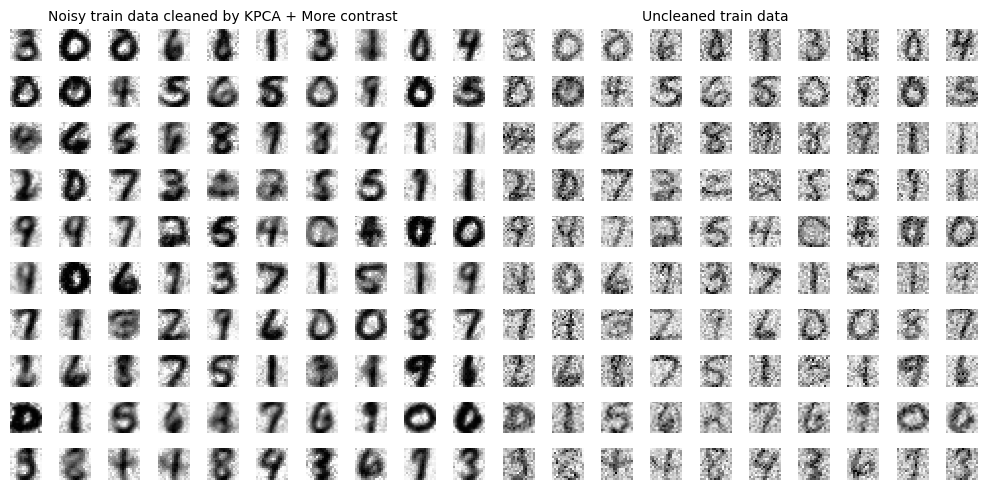

In [27]:
#X_contraste = X_contraste / 255.0
plot_parallel(X_contraste, X_train_noisy, "Noisy train data cleaned by KPCA + More contrast", "Uncleaned train data")

A continuación puede verse como son las imágenes con y sin contraste tras pasar por KPCA, en vez de una comparación directa con las imágenes con ruido.

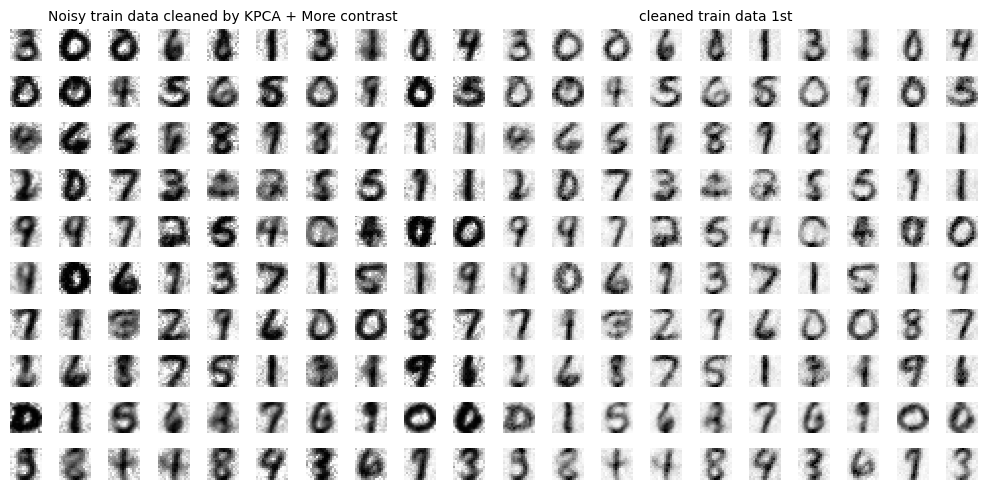

In [21]:
plot_parallel(X_contraste, X_back, "Noisy train data cleaned by KPCA + More contrast", "cleaned train data 1st")

Un posible segundo paso es eliminar toda aquella información de píxeles que se encuentren por debajo de un percentil, de forma que nos quedemos con las zonas con más información.

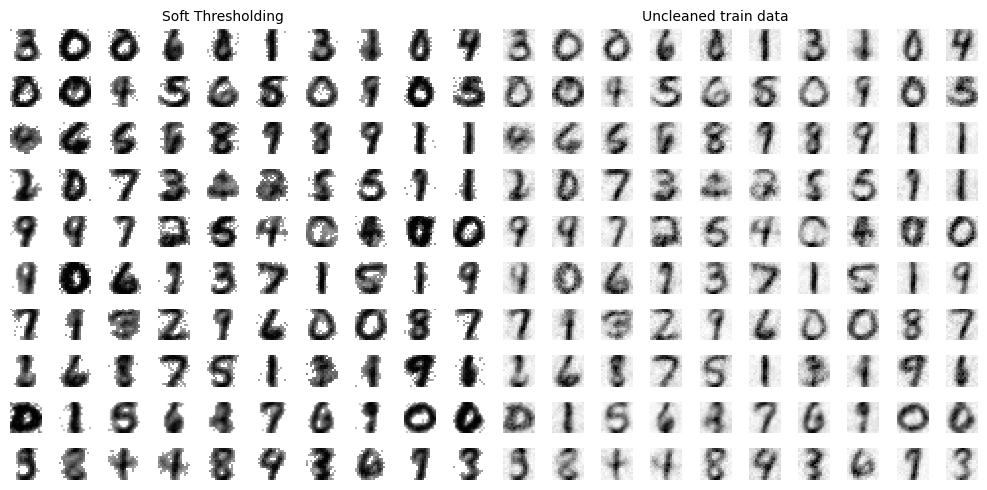

In [29]:
# Calcular el percentil 35 de valor de la imagen
percentil_35 = np.percentile(X_contraste, 40)

# Aplicar una máscara para establecer a 0 los píxeles por debajo del percentil 35
X_contraste_filtrado = np.where(X_contraste < percentil_35, 0, X_contraste)

plot_parallel(X_contraste_filtrado, X_back, "Soft Thresholding", "Uncleaned train data")

X_back_2 = X_contraste_filtrado / 255.0

Podemos ser más agresivos y umbralizar de forma que solo nos quedemos con aquellos valores que tengan el 60% o más del valor máximo de intensidad. Se aprecian mejor los números pero sigue resultando un poco rudo.

In [23]:
max_value = np.max(X_contraste)

# Calcular el umbral, que es el 60% del máximo valor
umbral = 0.66 * max_value

# Aplicar una máscara para establecer a 0 los píxeles por debajo del umbral
X_contraste_filtrado = np.where(X_contraste < umbral, 0, X_contraste)

X_back_2 = X_contraste_filtrado / 255.0

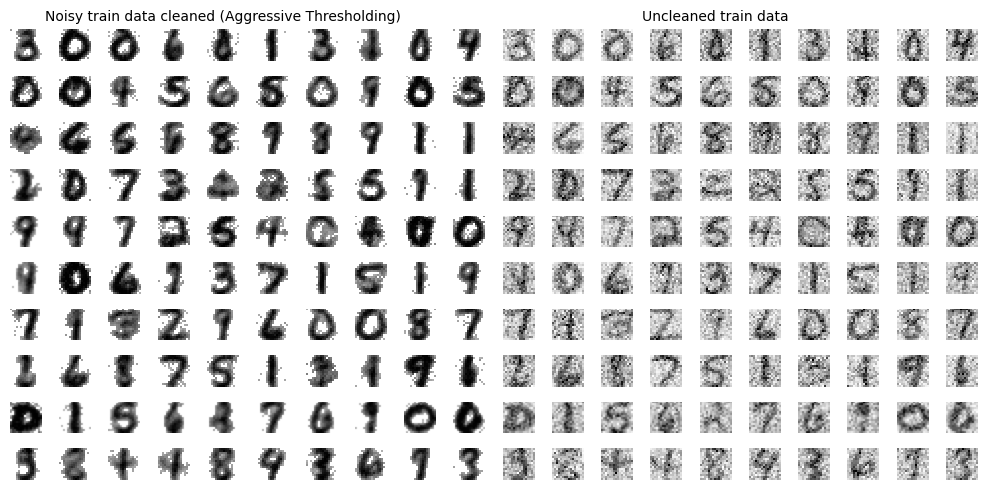

In [30]:
plot_parallel(X_back_2, X_train_noisy, "Noisy train data cleaned (Aggressive Thresholding)", "Uncleaned train data")

Nos gustaría comentar que hay más técnicas que son posibles de aplicar para limpiar los datos, usando filtrados gaussianos o transformadas wavelets. Pero eso no es el objetivo de esta tarea. Aquí hemos tratado de usar la KPCA para limpiar nuestras imágenes, siendo el objetivo "familiarizarnos con el algoritmo y su funcionamiento". Tal vez se podríamos continuar trabajano con los datos de test, pero creo que es más relevante entender que el parámetro gamma es realmente delicado.